# Lab06 - Textures
### TDS3651 Visual Information Processing


This lab will guide you on how to extract texture features. We first look at extracting simple textures from an image and how to find the cluster of different texture using K-Means.

We will then explore the Leung-Malik (LM) Filter Bank code provided by the Visual Geometry Group, University of Oxford. We first learn how to create a set of 48-D filters with the LM Filter Bank. Following that, we learn how to apply the filters in the filter bank onto an input image to create a 48-D texture histogram to represent the textures of the image and use thee texture histogram for image retrieval.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

## Extract Simple Image Features

The following program extract horizontal (dx) and vertical (dy) gradient features from an input image using the Sobel filter. The resulting Sobel detected gradients are thresholded to a binary image. Change the threshold value, `t` and observe how the threshold affects the plotted results.


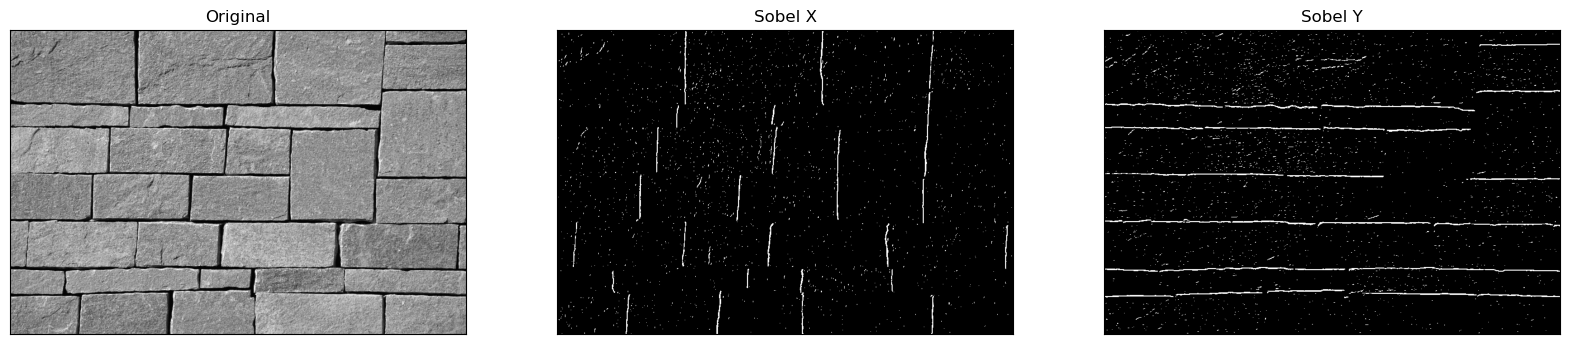

In [2]:
img = cv2.imread('brick2.jpg',0)

# Output dtype = cv2.CV_8U
sobelx8u = cv2.Sobel(img,cv2.CV_8U,1,0,ksize=3)
sobely8u = cv2.Sobel(img,cv2.CV_8U,0,1,ksize=3)
 
t = 200
ret,textureFeatx = cv2.threshold(sobelx8u,t,255,cv2.THRESH_BINARY)
ret,textureFeaty = cv2.threshold(sobely8u,t,255,cv2.THRESH_BINARY)
textureFeatx[textureFeatx==255] = 1
textureFeaty[textureFeaty==255] = 1

plt.figure(figsize=(20,20))
plt.subplot(1,3,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(textureFeatx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(textureFeaty ,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()


Next, we divide the images into grids of size 32x32 and compute the sum of the dx and dy responses. 

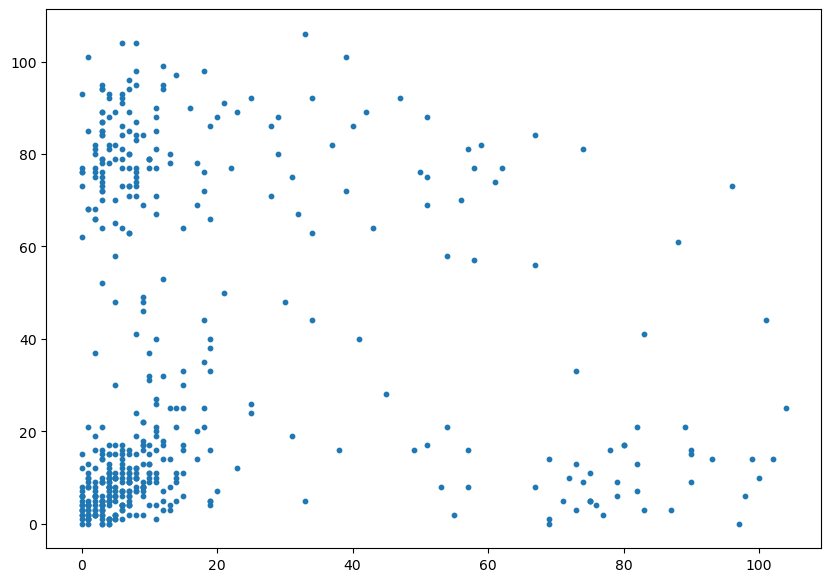

In [3]:
winsz = 32; #window size to get texture
#calculate sliding window steps
rows=int(textureFeatx.shape[0]/winsz)
cols=int(textureFeaty.shape[1]/winsz)
i=j=k=0
N = rows*cols #number of texture windows

#loop to sum up edges in window to form texture (can be mean or standard deviation)
dx=np.empty([N])
dy=np.empty([N])
for i in range(0, rows):
    for j in range(0, cols):
        dx[k] = sum(sum(textureFeatx[i*winsz:(i*winsz)+(winsz-1),j*winsz:(j*winsz)+(winsz-1)]))
        dy[k] = sum(sum(textureFeaty[i*winsz:(i*winsz)+(winsz-1),j*winsz:(j*winsz)+(winsz-1)]))
        k=k+1

plt.figure(figsize=(10,7))
plt.scatter(dx, dy, s=10)
plt.show()

**Perform K-Means clustering on the image grids** 

The following code uses the KMeans function from the sklearn package to find the texture-based clusters from the 2-D, dx and dy features. <br>
**Note**: Depending on your machine, this may take awhile to run.

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


[[ 6.89454545 10.30909091]
 [ 8.13533835 79.2406015 ]
 [77.27659574 12.44680851]
 [51.06451613 72.70967742]]


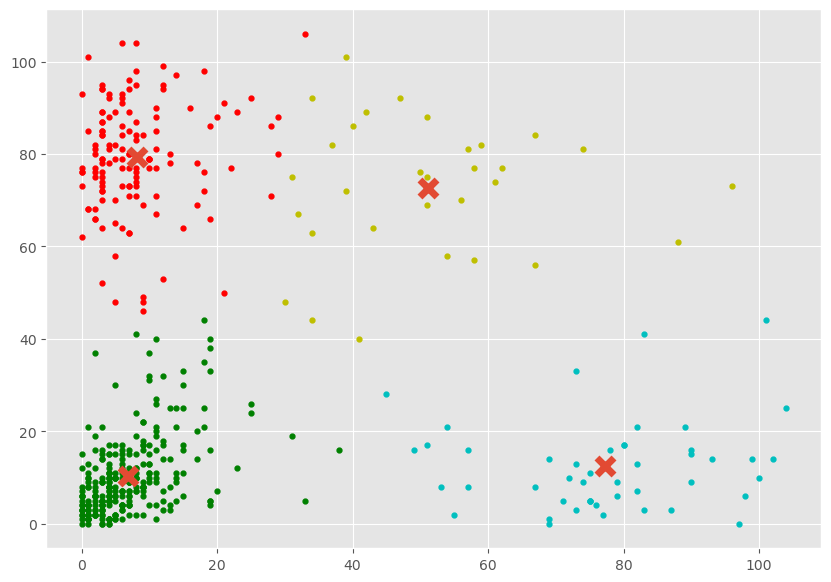

In [4]:
from matplotlib import style
style.use("ggplot")
from sklearn.cluster import KMeans

X1=np.zeros([dx.shape[0],2])
X1[:,0] = dx
X1[:,1] = dy

n_clusters=4
kmeans = KMeans(n_clusters)
kmeans.fit(X1)

centroids = kmeans.cluster_centers_
print(centroids)
labels = kmeans.labels_

colors = ["g.","r.","c.","y."]

plt.figure(figsize=(10,7))
for i in range(len(X1)):
    plt.plot(X1[i][0], X1[i][1], colors[labels[i]], markersize = 7)

plt.scatter(centroids[:, 0],centroids[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)
plt.show()

Alternatively, you can use the scipy version to support vector quantization. The cluster centers can be saved (as a codebook) to be re-used for clustering new data into the computed clusters.

[[ 7.6307693 79.09231  ]
 [ 6.8945456 10.309091 ]
 [49.205883  73.85294  ]
 [77.276596  12.446809 ]]
3
(486,)


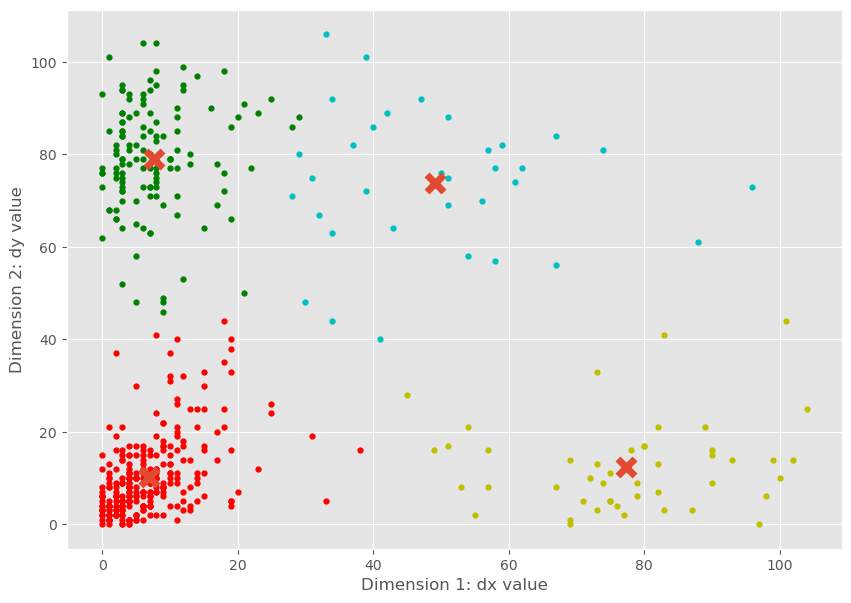

In [5]:
from matplotlib import style
from scipy.cluster.vq import kmeans, vq

X2=np.zeros([dx.shape[0],2])
X2[:,0] = dx
X2[:,1] = dy

n_clusters=4 
# k-means algo: data in MxN: M observations, N features 
codebook, _ = kmeans(np.float32(X2), n_clusters)    

# k by N codebook, showing k centroids of N-dimensions
print(codebook)

# VQ assigns each observation to its "code", which is its cluster label
code, _ = vq(np.float32(X2), codebook)
print(np.max(code))  # k=4 means labels are 0, 1, 2, 3
print(code.shape)

colors = ["g.","r.","c.","y."]

plt.figure(figsize=(10,7))
for i in range(len(X2)):
    plt.plot(X2[i][0], X2[i][1], colors[code[i]], markersize = 7)

plt.scatter(codebook[:, 0],codebook[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)
plt.xlabel('Dimension 1: dx value')
plt.ylabel('Dimension 2: dy value')
plt.show()

**Q1**: Create a visualization output to visualize the 4 clusters on the input image.

[Hint: An example of a visualization of the texture clusters is illustrated in Slide 24 of Lecture 7: Textures]

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Centroids: [[ 6.89454545 10.30909091]
 [ 8.13533835 79.2406015 ]
 [77.27659574 12.44680851]
 [51.06451613 72.70967742]]


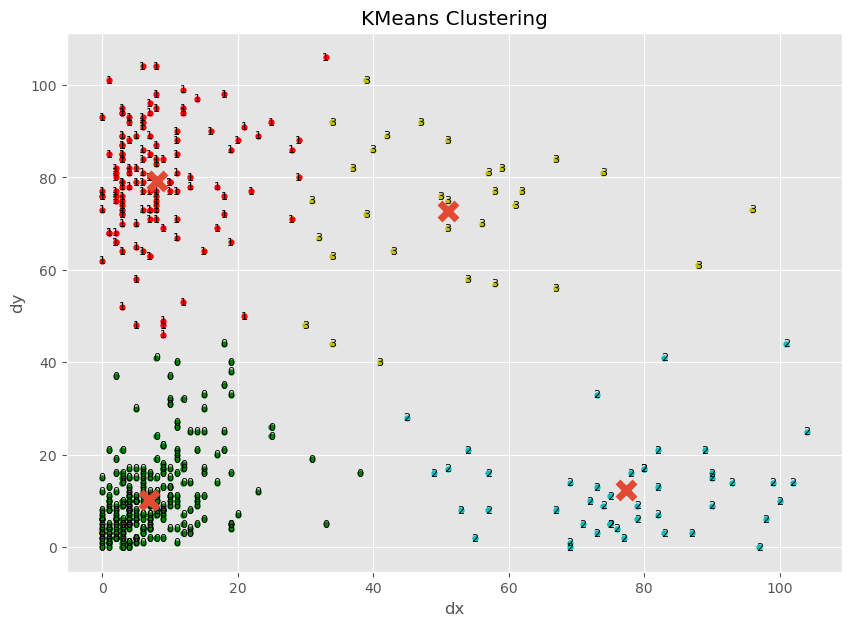

In [6]:
from matplotlib import style
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Rest of your code
style.use("ggplot")

X1 = np.zeros([dx.shape[0], 2])
X1[:, 0] = dx
X1[:, 1] = dy

n_clusters = 4
kmeans = KMeans(n_clusters)
kmeans.fit(X1)

centroids = kmeans.cluster_centers_
print("Centroids:", centroids)
labels = kmeans.labels_

colors = ["g.", "r.", "c.", "y."]

plt.figure(figsize=(10, 7))
for i in range(len(X1)):
    plt.plot(X1[i][0], X1[i][1], colors[labels[i]], markersize=7)
    plt.text(X1[i][0], X1[i][1], str(labels[i]), fontsize=8, color='k', ha='center', va='center')

plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=150, linewidths=5, zorder=10)
plt.title('KMeans Clustering')
plt.xlabel('dx')
plt.ylabel('dy')
plt.show()


(<Axes: >, <matplotlib.image.AxesImage at 0x151ded78e90>)

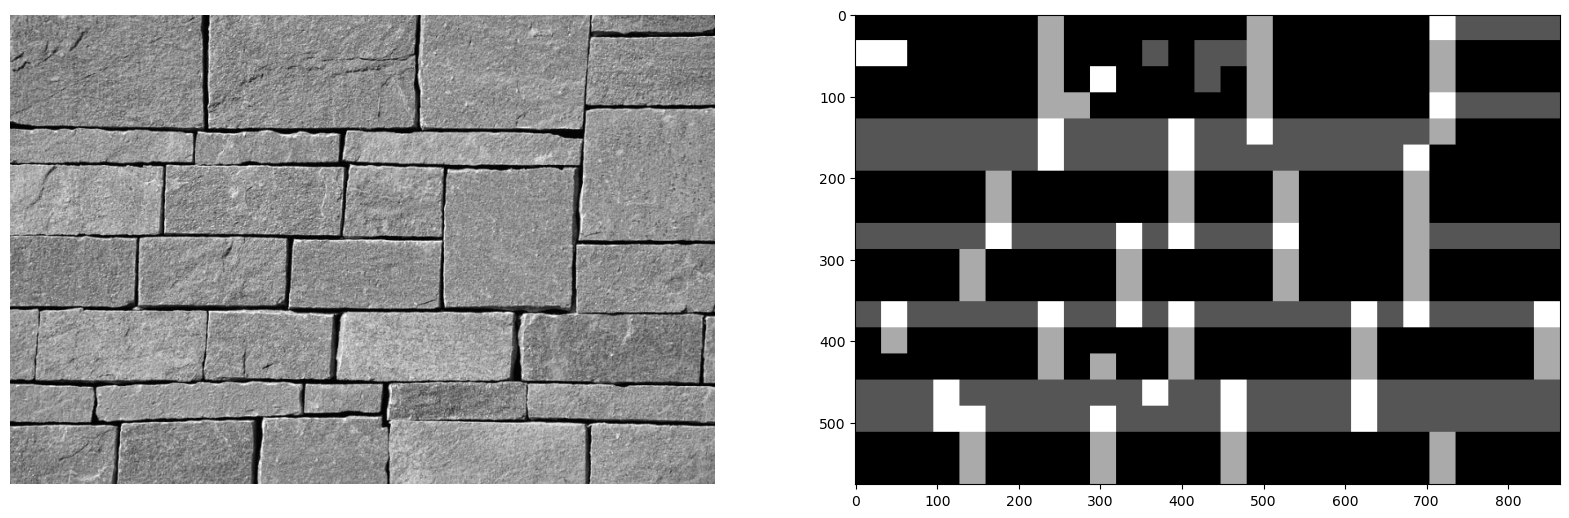

In [7]:
#1. Create empty image
vis_im = np.zeros(textureFeatx.shape)

#2. Loop rows and columns
#3. replace with labels
i = j = k = 0
for i in range (0, rows):
    for j in range(0, cols):
        vis_im[i*winsz:1+(i*winsz)+(winsz-1),j*winsz:1+(j*winsz)+(winsz-1)] = labels[k]
        k = k+1

plt.figure(figsize=(20,20))
style.use('default')
plt.subplot(1,2,1), plt.imshow(img,cmap='gray')
plt.axis('off')
plt.subplot(1,2,2), plt.imshow(vis_im, cmap='gray')

## Filter Bank

The Leung-Malik (LM) Filter Bank python implementation is provided in the lm.py file in the folder, 'LM_filter_bank'. The LM filter bank is a multi scale, multi orientation filter bank with 48 filters. It consists of first and second derivatives of Gaussians at 6 orientations and 3 scales making a total of 36; 8 Laplacian of Gaussian (LOG) filters; and 4 Gaussians.

The code to create the LM filter bank and display the respective filters are given below. Run the code snipplets to understand more about the filters provided by the LM filter bank.

Reference: http://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html

In [8]:
# Import the LM filter bank
from LM_filter_bank import lm

# Call the function to create a set of 48 filters
F = lm.makeLMfilters()

## First order derivative Gaussian Filter

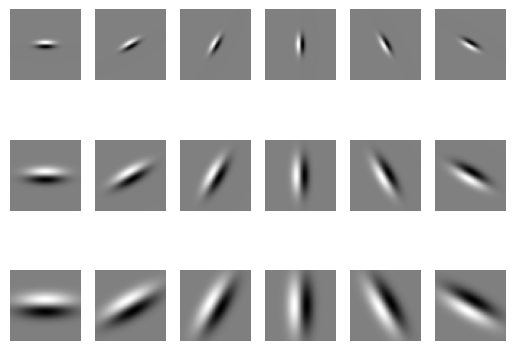

In [9]:
for i in range(0,18):
    plt.subplot(3,6,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i], cmap = 'gray')

## Second order derivative Gaussian Filter

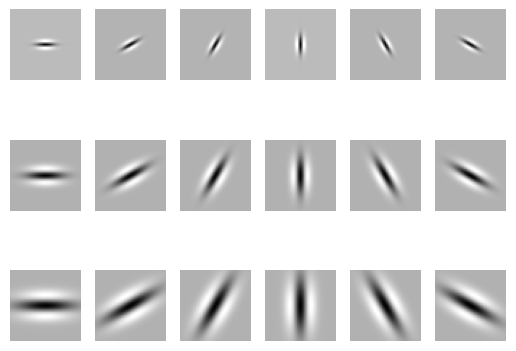

In [10]:
for i in range(0,18):
    plt.subplot(3,6,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i+18], cmap = 'gray')

## Gaussian and Laplacian Filter

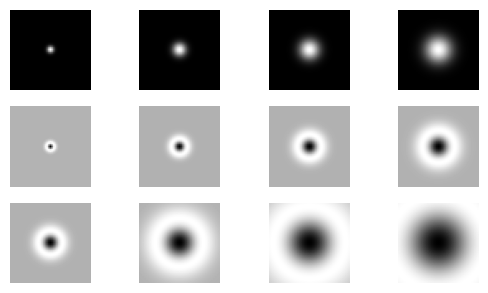

In [11]:
for i in range(0,12):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i+36], cmap = 'gray')

The LM Filter Bank provide 48 filters as illustrated above. The following code snipplet applies selected filters from the filter bank to an image. Run the program and then change the filter index to explore the results of different filters.

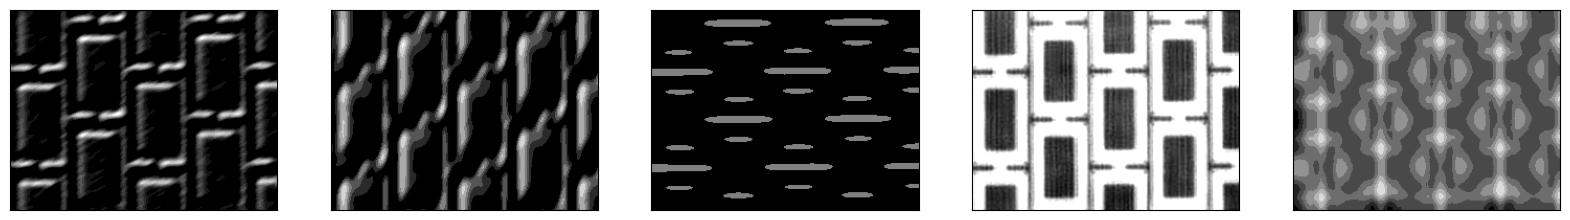

In [12]:
img = cv2.imread('carpet.jpg',0);

filterImg1 = cv2.filter2D(img,-1,F[:,:,1])    
filterImg2 = cv2.filter2D(img,-1,F[:,:,8])    
filterImg3 = cv2.filter2D(img,-1,F[:,:,30])    
filterImg4 = cv2.filter2D(img,-1,F[:,:,40])
filterImg5 = cv2.filter2D(img,-1,F[:,:,46])    

plt.figure(figsize=(20,20))
plt.subplot(1,5,1), plt.imshow(filterImg1, cmap='gray'),  plt.xticks([]), plt.yticks([])
plt.subplot(1,5,2), plt.imshow(filterImg2, cmap='gray'),  plt.xticks([]), plt.yticks([])
plt.subplot(1,5,3), plt.imshow(filterImg3, cmap='gray'),  plt.xticks([]), plt.yticks([])
plt.subplot(1,5,4), plt.imshow(filterImg4, cmap='gray'),  plt.xticks([]), plt.yticks([])
plt.subplot(1,5,5), plt.imshow(filterImg5, cmap='gray'),  plt.xticks([]), plt.yticks([])
plt.show()



**Q2**: **Write a function to return a texture histogram of a given image** 

Given an input image as the parameter, complete the textureHist function below that returns a texture historgram that consists of 48-D response obtained by applying the 48 filters of the Leong-Malik filter bank on the input image.

Hint: To support comparison of histogram features, normalize the histogram by the image size, ensure the clusters are the same every time.

In [13]:
print(img.shape)
print(F.shape)
print(X.shape)

n_clusters=F.shape[2]
for i in range(F.shape[2]):
    filtered = cv2.filter2D(img, -1,F[:,:,i])
    X[:,i] = filtered.flatten()

kmeans = KMeans(n_clusters,random_state=0)
kmeans.fit(X)
textures = kmeans.labels_

textHist,_ = np.histogram(textures, F.shape[2])
textHist = textHist/(img.shape[0]*img.shape[1])
return textHist

img = cv2.imread(path + 'waterdrop.jpg', 0)
test = 

**Q3**: **Compute similarity between images by comparing the texture histograms for image retrieval** 

Write a program to compute the texture similarity between the image, brickwall1.jpg with the following images <br>
    a) brickwall2.jpg <br>
    b) carpet.jpg <br>
    c) waterdrop.jpg

Make use of the above defined function, textureHist. Use either Euclidean distance or histogram intersection to compute the distance between the 48-D texture histograms of the respective images. Display the tetxure historgram of the each image, along with the distances between the image, brickwall1.jpg and the other 3 images.

Are the results accurate? Analyse the results and record your observation.

